In [1]:
import torch
import numpy as np
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
from collections import Counter

# === Load .npy files ===
X_seq = np.load("X_seq.npy")  # shape: (N, 100, 1024)
y_seq = np.load("y_seq.npy")  # shape: (N,)

# === Equalize classes ===
#class_counts = Counter(y_seq)
#min_count = min(class_counts.values())  # smallest class count (e.g. 40)

# Collect balanced indices
#selected_indices = []
#for cls in range(57):  # assuming classes are 0 to 56
 #   cls_indices = np.where(y_seq == cls)[0]
  #  chosen = np.random.choice(cls_indices, min_count, replace=False)
   # selected_indices.extend(chosen)

# Final balanced arrays
# X_balanced = X_seq[selected_indices]
# y_balanced = y_seq[selected_indices]

X_balanced = X_seq
y_balanced = y_seq

# === Split into train/test (stratified) ===
X_train_np, X_test_np, y_train_np, y_test_np = train_test_split(
    X_balanced, y_balanced, test_size=0.2, stratify=y_balanced, random_state=42
)

# === Further split train into train/val (stratified) ===
X_train_np, X_val_np, y_train_np, y_val_np = train_test_split(
    X_train_np, y_train_np, test_size=0.1, stratify=y_train_np, random_state=42
)

# === Convert to PyTorch tensors ===
X_train = torch.tensor(X_train_np, dtype=torch.float32)
y_train = torch.tensor(y_train_np, dtype=torch.long)
X_val = torch.tensor(X_val_np, dtype=torch.float32)
y_val = torch.tensor(y_val_np, dtype=torch.long)
X_test = torch.tensor(X_test_np, dtype=torch.float32)
y_test = torch.tensor(y_test_np, dtype=torch.long)

# === Wrap in TensorDataset ===
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
test_dataset = TensorDataset(X_test, y_test)

# === DataLoaders ===
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)

print("✅ Balanced DataLoaders ready:")
print(f"Train: {len(train_dataset)} | Val: {len(val_dataset)} | Test: {len(test_dataset)}")


✅ Balanced DataLoaders ready:
Train: 7726 | Val: 859 | Test: 2147


In [3]:
from sklearn.utils.class_weight import compute_class_weight

classes = np.unique(y_train_np)
class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train_np)
class_weight_dict = dict(zip(classes, class_weights))  # Map class → weight

# Step 2: Build per-sample weights from y_train_np
sample_weights = np.array([class_weight_dict[label] for label in y_train_np])

In [4]:
# Flatten (N, 100, 1024) → (N, 100*1024)
X_train_flat = X_train_np.reshape(X_train_np.shape[0], -1)
X_val_flat = X_val_np.reshape(X_val_np.shape[0], -1)
X_test_flat = X_test_np.reshape(X_test_np.shape[0], -1)

from sklearn.decomposition import PCA

# === Reduce dimensionality ===
pca = PCA(n_components=1024, random_state=42)
X_train_pca = pca.fit_transform(X_train_flat)
X_test_pca = pca.transform(X_test_flat)

In [5]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

# Logistic Regression with balanced class weights
logreg = LogisticRegression(max_iter=1000, class_weight=class_weight_dict)
logreg.fit(X_train_pca, y_train_np)
y_pred_logreg = logreg.predict(X_test_pca)

print("\n📊 Logistic Regression Accuracy:", accuracy_score(y_test_np, y_pred_logreg))
print(classification_report(y_test_np, y_pred_logreg))


📊 Logistic Regression Accuracy: 0.8798323241732651
              precision    recall  f1-score   support

           0       0.82      0.89      0.85       200
           1       0.67      0.75      0.71         8
           2       0.86      0.75      0.80         8
           3       1.00      1.00      1.00         8
           4       1.00      0.75      0.86         8
           5       0.90      0.93      0.91        94
           6       0.89      1.00      0.94         8
           7       0.89      1.00      0.94         8
           8       0.85      0.87      0.86       200
           9       1.00      0.88      0.93         8
          10       1.00      1.00      1.00         8
          11       1.00      0.88      0.93         8
          12       1.00      0.88      0.93         8
          13       0.78      0.88      0.82         8
          14       1.00      1.00      1.00         8
          15       0.89      1.00      0.94         8
          16       0.58      

In [6]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report

# === Naive Bayes (no class weighting support)
nb = GaussianNB()
nb.fit(X_train_pca, y_train_np)
y_pred_nb = nb.predict(X_test_pca)

print("📊 Naive Bayes Accuracy:", accuracy_score(y_test_np, y_pred_nb))
print("\n📄 Classification Report (Naive Bayes):")
print(classification_report(y_test_np, y_pred_nb))

📊 Naive Bayes Accuracy: 0.5663716814159292

📄 Classification Report (Naive Bayes):
              precision    recall  f1-score   support

           0       0.30      0.73      0.42       200
           1       0.67      0.25      0.36         8
           2       1.00      0.50      0.67         8
           3       0.64      0.88      0.74         8
           4       0.33      0.62      0.43         8
           5       0.71      0.23      0.35        94
           6       0.80      1.00      0.89         8
           7       1.00      0.75      0.86         8
           8       0.81      0.51      0.62       200
           9       0.71      0.62      0.67         8
          10       0.89      1.00      0.94         8
          11       1.00      0.62      0.77         8
          12       0.62      0.62      0.62         8
          13       1.00      0.75      0.86         8
          14       0.56      0.62      0.59         8
          15       0.67      0.75      0.71         

In [ ]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report

# === SVM ===
print("\n🔧 Training SVM...")
svm = SVC(kernel='rbf', C=1, gamma='scale')
svm.fit(X_train_pca, y_train_np)  # ✅ Train on train set
y_pred_svm = svm.predict(X_test_pca)  # ✅ Predict on test set
print("📊 SVM Accuracy:", accuracy_score(y_test_np, y_pred_svm))




🔧 Training SVM...
📊 SVM Accuracy: 0.831858407079646


In [10]:
print(classification_report(y_test_np, y_pred_svm))

              precision    recall  f1-score   support

           0       0.73      0.86      0.79       200
           1       0.83      0.62      0.71         8
           2       0.83      0.62      0.71         8
           3       0.86      0.75      0.80         8
           4       0.05      0.12      0.07         8
           5       0.86      0.83      0.84        94
           6       1.00      0.75      0.86         8
           7       1.00      0.75      0.86         8
           8       0.83      0.92      0.87       200
           9       1.00      0.62      0.77         8
          10       1.00      1.00      1.00         8
          11       1.00      0.62      0.77         8
          12       1.00      0.88      0.93         8
          13       0.89      1.00      0.94         8
          14       0.67      0.50      0.57         8
          15       1.00      0.75      0.86         8
          16       0.86      0.75      0.80         8
          17       0.86    

In [8]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

print("\n🔧 Training Random Forest (with PCA)...")
rf = RandomForestClassifier(
    n_estimators=100,
    max_depth=20,
    random_state=42,
    n_jobs=-1  # Use all CPU cores
)
rf.fit(X_train_pca, y_train_np)
y_pred_rf = rf.predict(X_test_pca)

print("📊 Random Forest Accuracy:", accuracy_score(y_test_np, y_pred_rf))
print("\n📄 Classification Report (Random Forest with PCA):")
print(classification_report(y_test_np, y_pred_rf))



🔧 Training Random Forest (with PCA)...
📊 Random Forest Accuracy: 0.7987890079180252

📄 Classification Report (Random Forest with PCA):
              precision    recall  f1-score   support

           0       0.70      0.89      0.78       200
           1       1.00      0.12      0.22         8
           2       1.00      0.62      0.77         8
           3       0.86      0.75      0.80         8
           4       0.00      0.00      0.00         8
           5       0.91      0.74      0.82        94
           6       1.00      0.25      0.40         8
           7       1.00      0.62      0.77         8
           8       0.78      0.89      0.83       200
           9       1.00      0.50      0.67         8
          10       1.00      0.88      0.93         8
          11       1.00      0.62      0.77         8
          12       1.00      0.75      0.86         8
          13       0.80      0.50      0.62         8
          14       1.00      0.25      0.40         8

c:\Users\nasrr\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\nasrr\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\nasrr\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

In [9]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report

print("\n🔧 Training XGBoost (GPU)...")

# === Initialize XGBoost with GPU settings
xgb = XGBClassifier(
    n_estimators=100,
    max_depth=6,
    tree_method='hist',   # use GPU-accelerated hist method
    device='cuda',        # explicitly set GPU device
    eval_metric='mlogloss',
    random_state=42
)

# === Fit on PCA-reduced training data (on CPU — XGBoost handles internally)
xgb.fit(X_train_pca, y_train_np)

# === Predict (XGBoost will handle device transfer automatically)
y_pred_xgb = xgb.predict(X_test_pca)

# === Evaluate
print("📊 XGBoost Accuracy (GPU, PCA):", accuracy_score(y_test_np, y_pred_xgb))
print("\n📄 Classification Report:")
print(classification_report(y_test_np, y_pred_xgb))



🔧 Training XGBoost (GPU)...


c:\Users\nasrr\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:30:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


📊 XGBoost Accuracy (GPU, PCA): 0.8262692128551468

📄 Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.86      0.81       200
           1       0.25      0.12      0.17         8
           2       1.00      0.62      0.77         8
           3       0.78      0.88      0.82         8
           4       0.60      0.38      0.46         8
           5       0.92      0.83      0.87        94
           6       0.78      0.88      0.82         8
           7       0.88      0.88      0.88         8
           8       0.85      0.85      0.85       200
           9       1.00      0.50      0.67         8
          10       1.00      1.00      1.00         8
          11       0.86      0.75      0.80         8
          12       0.58      0.88      0.70         8
          13       1.00      1.00      1.00         8
          14       0.75      0.75      0.75         8
          15       0.80      0.50      0.62         8
     

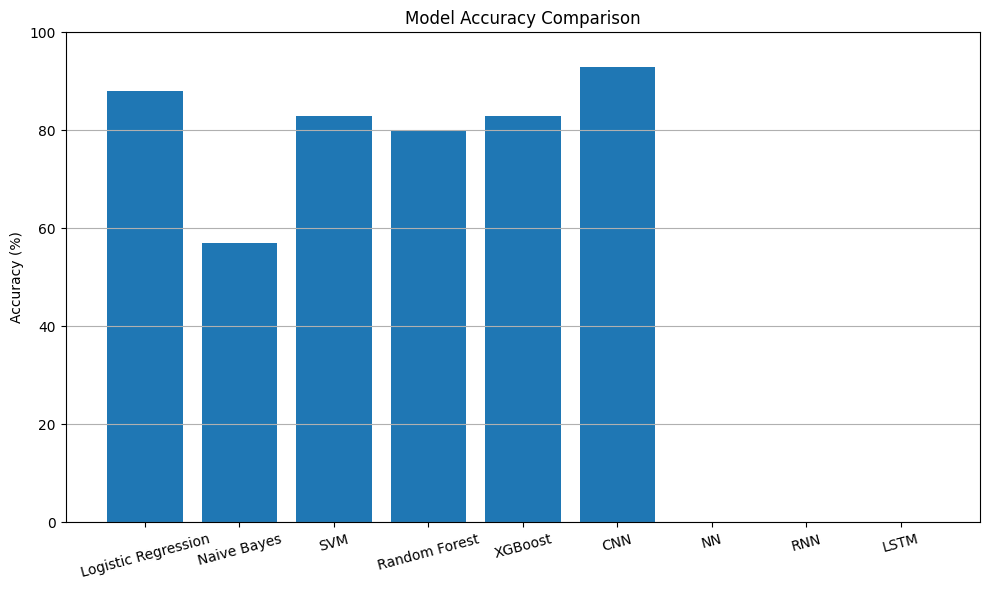

In [17]:
import matplotlib.pyplot as plt

model_names = [
    "Logistic Regression", 
    "Naive Bayes", 
    "SVM", 
    "Random Forest", 
    "XGBoost", 
    "CNN",
    "NN",
    "RNN",
    "LSTM"
]

accuracies = [0.88, 0.57, 0.83, 0.80, 0.83, 0.93, 0.00, 0.00, 0.00]

# Convert to percentage
accuracy_percent = [a * 100 for a in accuracies]

plt.figure(figsize=(10, 6))
plt.bar(model_names, accuracy_percent)
plt.ylabel("Accuracy (%)")
plt.title("Model Accuracy Comparison")
plt.ylim(0, 100)
plt.grid(axis='y')
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()
